PCA可视为对数据变化的分区；PCA通常应用于标准化数据(对于标准化数据，变化意味着相关性；对于非标准化数据，变化意味着协方差)

# 主成分分析Principal Component Analysis

PCA理念：不是用原始特征描述数据，而是用其变化轴描述它。变化轴就成为了新的特征。

PCA构造的新特征实际上只是原始特征的线性组合(加权和)。

df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]；df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
例子中的新特征构建(其实很好理解，线性关系一次函数可以用横纵坐标表示)

这些新特征称为数据的主成分。权重本身称为载荷。主成分与原始数据集中特征数量一样多

# 面向特征工程的PCA PCA for Feature Engineering

方法一：将其作为一种描述性技术。由于组分显示了变化，因此可以计算分量的MI分数，并查看哪种变化最能预测你的目标。例如，如果“尺寸”很重要，则为“高度”和“直径”的乘积，如果“形状”很重要，则为“高度”和“直径”的比率。还可以尝试在一个或多个高分组分上进行聚类。

方法二：将组分本身作为特征，由于组分直接公开了数据的变化结构，因此它们通常比原始特征更具有信息性。1.降维：当特征高度冗余时(特别是多重共线)，PCA会将冗余划分为一个或多个接近0方差的分量然后可以删除这些分量，因为他们几乎不包含信息；2.异常检测：从原始特征中不明显的异常变化通常会出现在低方差分量中，这些分量在异常或异常值检测时具有很高的信息量；3.降噪：传感器读数的集合通常会共享一些共同的背景噪声。PCA有时可以将(信息性)信号收集到较少的特征中，而不受噪声的影响，提高信噪比；4.去相关：一些ML算法在处理高度相关的特征时会遇到困难，PCA可以将相关的特征转化为不相关的成分，便于算法处理。

PCA最佳实践：1.仅适用于数字特征，如连续数量或计数；2.PCA对比例很敏感，最好在应用PCA前对数据进行标准化；3.考虑删除或约束异常值。

# 示例

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


sns.set_style("whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("D:/vscode/vscode_python/feature_engineering/data/autos.csv")

In [6]:
features=["highway_mpg","engine_size","horsepower","curb_weight"]

X=df.copy()
y=X.pop("price")
X=X.loc[:,features]

#数据标准化：X-X平均值/X标准差
X_scaled=(X-X.mean(axis=0))/X.std(axis=0)

In [8]:
#拟合主成分：
from sklearn.decomposition import PCA

#创建主成分：
pca=PCA()
X_pca=pca.fit_transform(X_scaled)

component_names=[f"PC{i+1}"for i in range(X_pca.shape[1])]
X_pca=pd.DataFrame(X_pca,columns=component_names)

X_pca

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138
...,...,...,...,...
188,0.869097,-0.033610,-0.322867,-0.169687
189,1.784896,-0.335345,0.407270,-0.652607
190,1.938892,-0.096703,-0.051044,0.275515
191,1.137520,-0.032469,-0.826623,-0.219731


In [10]:
loadings=pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)

loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

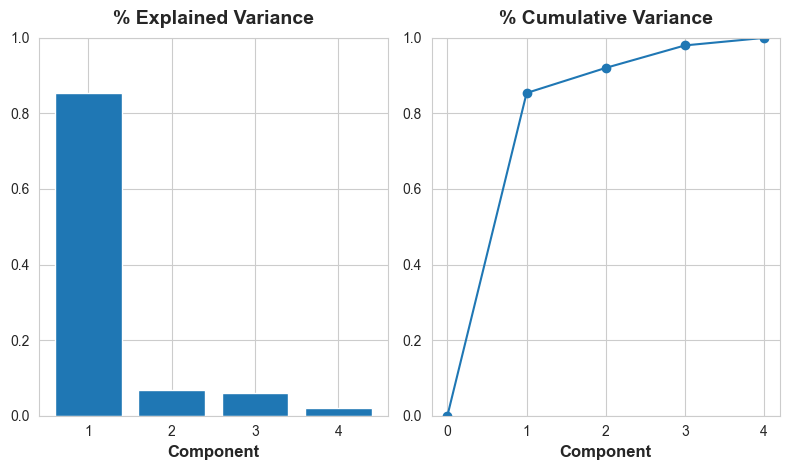

In [11]:
plot_variance(pca)

In [12]:
mi_scores=make_mi_scores(X_pca,y,discrete_features=False)
mi_scores

PC1    1.013217
PC2    0.379198
PC3    0.306273
PC4    0.204371
Name: MI Scores, dtype: float64

In [14]:
idx=X_pca["PC3"].sort_values(ascending=False).index
cols=["make","body_style","horsepower","curb_weight"]
df.loc[idx,cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


<Axes: xlabel='sports_or_wagon', ylabel='price'>

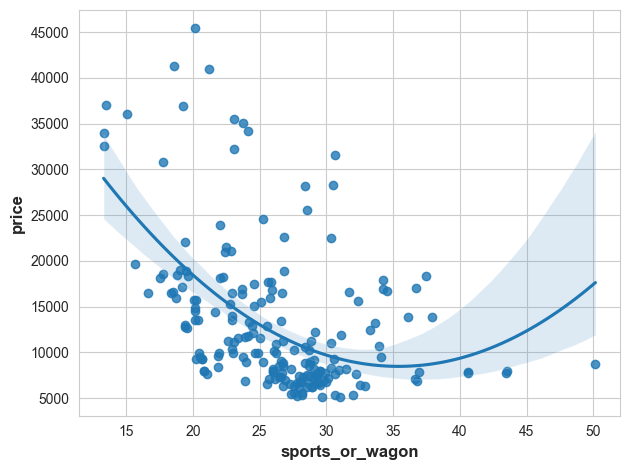

In [15]:
df["sports_or_wagon"]=X.curb_weight/X.horsepower
sns.regplot(x="sports_or_wagon",y="price",data=df,order=2)